In [1]:
"""
Retrieve predicted probabilities for roof material classes from ResNet-18 models (CV)
"""

import sys, os, gc

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsat.models.classification import resnet18
from torch.nn.functional import softmax

# Custom functions (__functions.py)
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
homedir = '/home/jovyan' # cyverse

# results_dir = os.path.join(maindir, 'results/resnet18/')
results_dir = os.path.join(homedir, 'results/resnet18-cv/')
print(results_dir)

print("Imports successful !")

/home/jovyan/results/resnet18-cv/
Imports successful !


In [2]:
def initialize_resnet_model(n_classes, n_bands, device, learning_rate, momentum, weight_decay, patience):
    """
    Initializes the ResNet-18 model, optimizer, scheduler, scaler, and loss criterion.
    
    Args:
        n_classes (int): Number of output classes.
        n_bands (int): Number of input image bands.
        device (torch.device): Device to run the model on (CPU/GPU).
        learning_rate (float): Learning rate for the optimizer.
        momentum (float): Momentum for SGD optimizer.
        weight_decay (float): Weight decay for SGD optimizer.
        patience (int): Patience for learning rate scheduler.

    Returns:
        model (torch.nn.Module): The initialized model.
        optimizer (torch.optim.Optimizer): The optimizer.
        lr_scheduler (torch.optim.lr_scheduler): The learning rate scheduler.
        scaler (torch.cuda.amp.GradScaler): The scaler for mixed precision.
    """
    # Initialize the Resnet-18 model
    model = resnet18(n_classes, in_channels=n_bands, pretrained=False)
    # Move the model to the specified device
    if torch.cuda.device_count() >= 1:
        model = nn.DataParallel(model)
        model.to(device)
    else:
        model = nn.DataParallel(model)
        model.to(device)
        print('Made CPU parallel')

    # Define the optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    
    # Define the learning rate scheduler
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=False, min_lr=1e-6)
    
    # Initialize the scaler for mixed precision
    scaler = torch.cuda.amp.GradScaler()

    return model, optimizer, lr_scheduler, scaler

print("Function to load ResNet-18 model ready !")

Function to load ResNet-18 model ready !


In [3]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'opp-data/denver_0815_psscene8b_final_norm.tif')
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()
n_bands = stack_da.values.shape[:1][0] # get a list of band names
print(
    f"shape: {stack_da.rio.shape}\n"
    f"bands: {n_bands}\n"
    f"resolution: {stack_da.rio.resolution()}\n"
    f"bounds: {stack_da.rio.bounds()}\n"
    f"sum: {stack_da.sum().item()}\n"
    f"CRS: {stack_da.rio.crs}\n"
    f"NoData: {stack_da.rio.nodata}\n"
    f"Array: {stack_da}"
)
del stack_da

shape: (14939, 6330)
bands: 6
resolution: (3.0, -3.0)
bounds: (489558.0, 4383960.0, 508548.0, 4428777.0)
sum: 15.8248291015625
CRS: EPSG:32613
NoData: None
Array: <xarray.DataArray (band: 6, y: 14939, x: 6330)> Size: 2GB
[567383220 values with dtype=float32]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 51kB 4.896e+05 4.896e+05 ... 5.085e+05 5.085e+05
  * y            (y) float64 120kB 4.429e+06 4.429e+06 ... 4.384e+06 4.384e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5')


In [4]:
# Perform predictions on the holdout data for each model

In [5]:
# Load the holdout data
# holdout_df = gpd.read_file(os.path.join(results_dir, 'cv-results/denver-resnet18_cv_holdout_ref.gpkg'))
holdout_df = gpd.read_file(os.path.join(results_dir, 'denver-resnet18_cv_holdout_ref.gpkg'))
print("Holdout set class distribution:\n", holdout_df[['class_code','code']].value_counts())

Holdout set class distribution:
 class_code  code
CS          6       17313
WS          1        2129
AP          3        1624
TL          0         569
CN          2         552
TG          5          46
SL          4          46
Name: count, dtype: int64


In [6]:
# Create dictionaries for mapping
code_mapping = dict(zip(holdout_df['code'], holdout_df['class_code']))  # Mapping to original 'class_code'
desc_mapping = dict(zip(holdout_df['code'], holdout_df['description']))
print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{0: 'TL', 1: 'WS', 2: 'CN', 3: 'AP', 4: 'SL', 5: 'TG', 6: 'CS'}
Description map: 
{0: 'Tile', 1: 'Wood shake/shingle', 2: 'Concrete', 3: 'Asphalt', 4: 'Slate', 5: 'Tar and gravel', 6: 'Composition Shingle'}


In [7]:
# Best params from tuning
params = {'window_size': 78, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.01, 'momentum': 0.85, 'patience': 5}
print(f'Model params: {params}')

Model params: {'window_size': 78, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.01, 'momentum': 0.85, 'patience': 5}


In [8]:
# Load the holdout data into Torch
holdout_ds = RoofImageDatasetPlanet(holdout_df[['geometry', 'code']], img_path=stack_da_fp, n_bands=n_bands, img_dim=params['window_size'])
holdout_loader = DataLoader(holdout_ds, batch_size=params['batch_size'] * 2, num_workers=2, shuffle=False, pin_memory=True)
print("Holdout data loaded !")

Holdout data loaded !


In [9]:
# Define whether to leverage cpu or gpu (for my local machine it is only cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
print(f'Using {device} for model eval ...')

Using cuda for model eval ...


In [10]:
n_folds = 5
n_classes = len(code_mapping.keys())

# Initialize list to store the results:
all_preds = []
# loop the trained models and make predictions
for fold_idx in range(1, n_folds + 1):
    print(f"Making predictions with model from fold {fold_idx}")

    # Load the trained model for the current fold
    # model_fp = os.path.join(results_dir, f'cv-models/denver-resnet18_fold{fold_idx}.pth')
    model_fp = os.path.join(results_dir, f'denver-resnet18_fold{fold_idx}.pth')
    print(f"Loading model from path: {model_fp}")
    checkpoint = torch.load(model_fp, map_location=device)

    # Initialize the model architecture
    model, _, _, _ = initialize_resnet_model(
        n_classes=n_classes,
        n_bands=n_bands,
        device=device,
        learning_rate=params['learning_rate'],
        momentum=params['momentum'],
        weight_decay=params['weight_decay'],
        patience=params['patience']
    )

    # Load the trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set the model to evaluation mode
    
    true_codes = []
    pred_codes = []
    pred_probs = [] 
    
    # Make predictions on the holdout data
    with torch.no_grad():
        for idx, sample in enumerate(holdout_loader):
            image, label = sample['image'].to(device), sample['code'].to(device)

            # Get the model's predictions
            output = model(image.float())
            # Apply softmax to get probabilities
            probabilities = softmax(output, dim=1).cpu().numpy()
            # Apply argmax to get the predicted class
            predictions = output.argmax(dim=1).cpu().numpy()

            # Store true labels, predictions, and probabilities
            true_codes.extend(label.cpu().numpy())
            pred_codes.extend(predictions)
            pred_probs.extend(probabilities)

            if idx % 10 == 0:
                print(f"\tProcessed {idx * params['batch_size']} samples")

    # Map true and predicted labels to their class codes
    true_class_codes = [code_mapping[code] for code in true_codes]
    pred_class_codes = [code_mapping[pred] for pred in pred_codes]

    # Store true and predicted labels in a dataframe
    fold_df = pd.DataFrame({
        'fold_idx': fold_idx,         
        'true_code': true_codes,
        'pred_code': pred_codes,
        'true_label': true_class_codes,
        'pred_label': pred_class_codes
    })

    # Add predicted probabilities for each class as seperate columns
    for class_idx in range(n_classes):
        class_label = code_mapping[class_idx]
        fold_df[f"{class_label}"] = [prob[class_idx] for prob in pred_probs]
    
    all_preds.append(fold_df)

    del model
    if device == 'cuda':
        torch.cuda.empty_cache()
    gc.collect()

# concatenate across folds
preds_df = pd.concat(all_preds, ignore_index=True)

# Save the predictions for later analysis
# preds_df.to_csv(os.path.join(results_dir, 'cv-results/denver-resnet18_cv_holdout_prob_preds.csv'), index=False)
preds_df.to_csv(os.path.join(results_dir, 'denver-resnet18_cv_holdout_prob_preds.csv'), index=False)
print("Completed predictions for all folds!")

Making predictions with model from fold 1
Loading model from path: /home/jovyan/results/resnet18-cv/denver-resnet18_fold1.pth
	Processed 0 samples
	Processed 640 samples
	Processed 1280 samples
	Processed 1920 samples
	Processed 2560 samples
	Processed 3200 samples
	Processed 3840 samples
	Processed 4480 samples
	Processed 5120 samples
	Processed 5760 samples
	Processed 6400 samples
	Processed 7040 samples
	Processed 7680 samples
	Processed 8320 samples
	Processed 8960 samples
	Processed 9600 samples
	Processed 10240 samples
	Processed 10880 samples
Making predictions with model from fold 2
Loading model from path: /home/jovyan/results/resnet18-cv/denver-resnet18_fold2.pth
	Processed 0 samples
	Processed 640 samples
	Processed 1280 samples
	Processed 1920 samples
	Processed 2560 samples
	Processed 3200 samples
	Processed 3840 samples
	Processed 4480 samples
	Processed 5120 samples
	Processed 5760 samples
	Processed 6400 samples
	Processed 7040 samples
	Processed 7680 samples
	Processed

In [11]:
gc.collect()

0

In [12]:
preds_df.head()

,fold_idx,true_code,pred_code,true_label,pred_label,TL,WS,CN,AP,SL,TG,CS
0,1,0,6,TL,CS,0.032015,0.013132,0.001568,0.012539,0.001279,0.012027,0.927441
1,1,0,1,TL,WS,0.321662,0.625410,0.026253,0.002346,0.017403,0.001485,0.005442
2,1,0,0,TL,TL,0.949962,0.036828,0.004942,0.000927,0.002765,0.002140,0.002435
3,1,0,0,TL,TL,0.811693,0.105146,0.047873,0.004628,0.023397,0.004614,0.002649
4,1,0,0,TL,TL,0.946499,0.019475,0.016333,0.001294,0.006534,0.006109,0.003756


In [13]:
# Create the AUC-PR plots

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

AUC-PR for TL: 0.6677


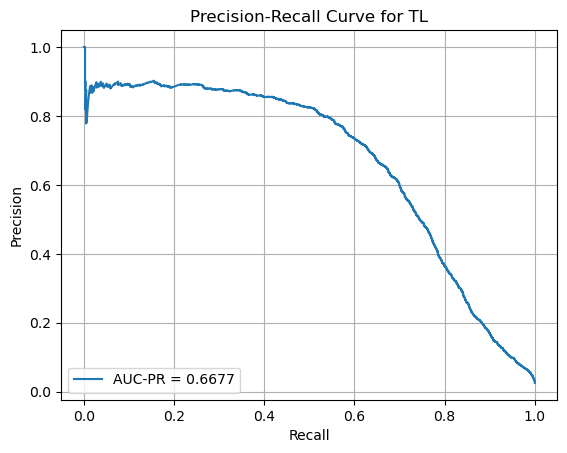

AUC-PR for WS: 0.6412


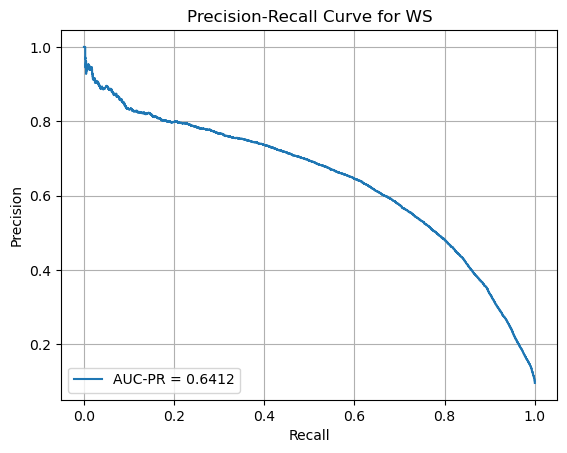

AUC-PR for CN: 0.8874


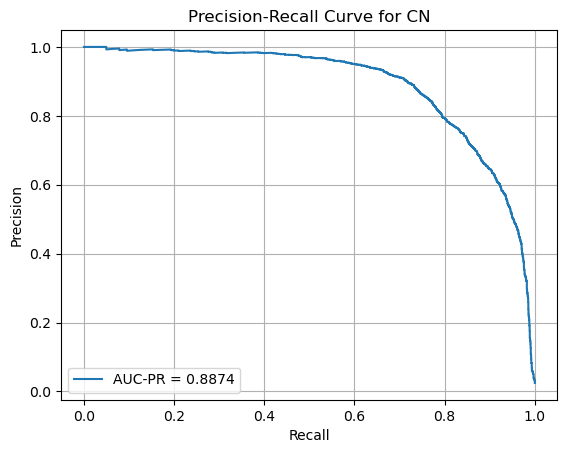

AUC-PR for AP: 0.9052


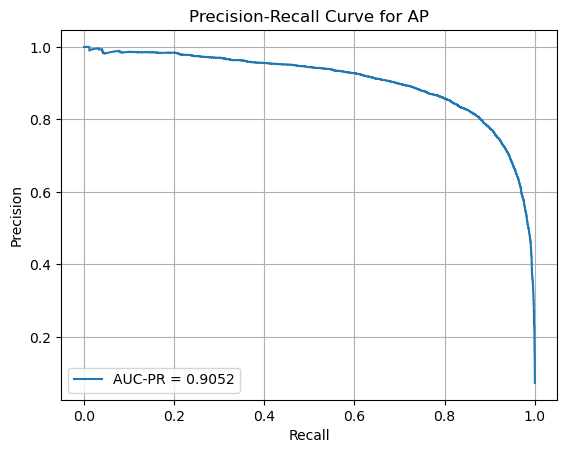

AUC-PR for SL: 0.0611


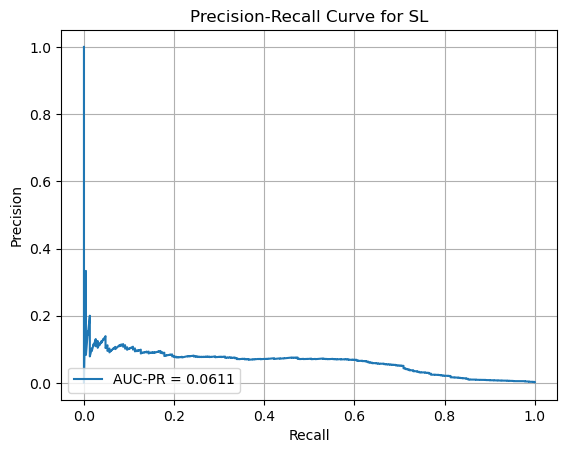

AUC-PR for TG: 0.1271


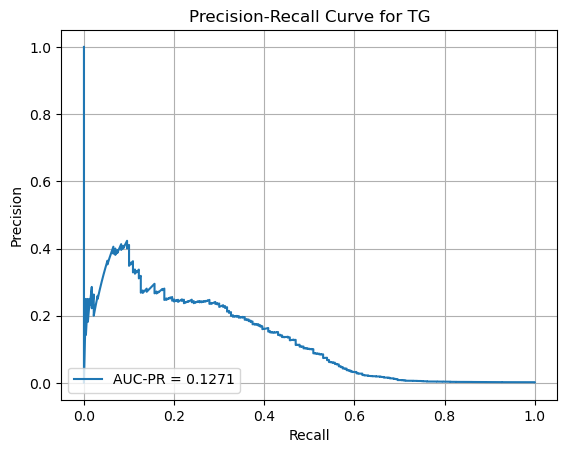

AUC-PR for CS: 0.9870


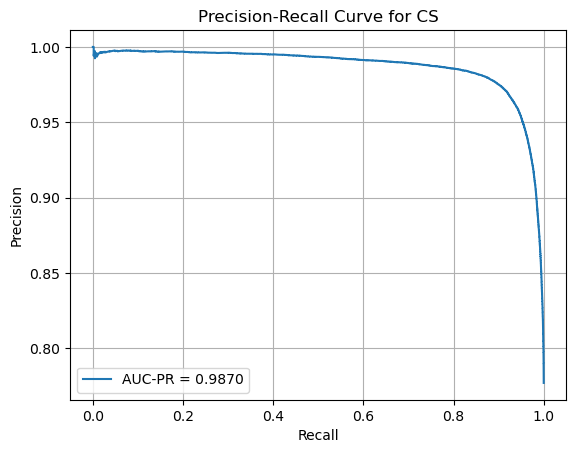

In [15]:
for class_idx, class_code in code_mapping.items():
    # Binary true labels for the current class (1 if true label == class_idx, else 0)
    true_binary = (preds_df['true_code'] == class_idx).astype(int)
    
    # Predicted probabilities for the current class
    pred_probs = preds_df[f'{class_code}']
    
    # Calculate precision, recall, and thresholds for the current class
    precision, recall, _ = precision_recall_curve(true_binary, pred_probs)
    
    # Compute AUC-PR for the current class
    auc_pr = auc(recall, precision)
    print(f"AUC-PR for {class_code}: {auc_pr:.4f}")
    
    # Plot Precision-Recall curve
    plt.figure()
    plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {class_code}')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()